In [22]:
import numpy as np
import time

import torch
from torch import nn
from torch import optim
import torch.nn.functional as F
from torch.autograd import Variable
import torch.utils.data as utils

import helper

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [23]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from numpy.linalg import norm

matplotlib.rcParams['text.usetex'] = True
matplotlib.rcParams['text.latex.unicode'] = True

# For the notebook
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [24]:
biwi = pd.read_csv('./data/train/biwi/biwi_hotel.txt', header = None,
                 names = ['frameNb','id', 'x','y'],delimiter=' ')
id_unique = np.unique(np.array(biwi['id']))

init = np.zeros(len(biwi)) 
biwi['Speed'] = init
biwi['Angle'] = init
biwi['Vx'] = init
biwi['Vy'] = init

In [25]:
pd.options.mode.chained_assignment = None ## Disable StettingWithCopy warning
c = 0
for i in id_unique:
    a = biwi[biwi['id']==i]
    ind = a.index
    a.index = range(len(a))
    dist = a['x'].iloc
    dist1 = a.loc[0:len(a)-2,'x':'y']
    dist1.index=range(len(dist1))
    dist2 = a.loc[1:,'x':'y']
    dist2.index=range(len(dist2))
    dist = dist2-dist1
    b = len(dist)
    if c < b:
        vector_speed = np.zeros((len(id_unique),b,2))
        c=b
b = 0
for i in id_unique:
    a = biwi[biwi['id']==i]
    ind = a.index
    a.index = range(len(a))
    dist = a['x'].iloc
    dist1 = a.loc[0:len(a)-2,'x':'y']
    dist1.index=range(len(dist1))
    dist2 = a.loc[1:,'x':'y']
    dist2.index=range(len(dist2))
    dist = dist2-dist1
    speed = np.array(np.sqrt(dist['x']**2+dist['y']**2)/0.4)
    biwi.loc[ind[1:],'Speed'] = speed
    angle=np.zeros(len(dist)-1)
    vx=np.zeros(len(dist))
    vy=np.zeros(len(dist))
    for j in range(len(dist)-1):
        if norm(dist.loc[j,:])==0 or norm(dist.loc[j+1,:])==0:
            angle[j]=0
        elif np.cross(dist.loc[j,:],dist.loc[j+1,:])/(norm(dist.loc[j,:])*norm(dist.loc[j+1,:]))>1:
            angle[j]=np.arcsin(1)
        else:
            angle[j]=np.arcsin(np.cross(dist.loc[j,:],dist.loc[j+1,:])/(norm(dist.loc[j,:])*norm(dist.loc[j+1,:])))
    
    for j in range(len(dist)):
        if j == 0:
            vx[j] = 0
            vy[j] = speed[j]
            vector_speed[b][j][0]=vx[j]
            vector_speed[b][j][1]=vy[j]
        else:
            vx[j] = speed[j]*np.sin(sum(angle[:j]))
            vy[j] = speed[j]*np.cos(sum(angle[:j]))
            vector_speed[b][j][0]=vx[j]
            vector_speed[b][j][1]=vy[j]
    
    biwi.loc[ind[2:],'Angle'] = angle
    biwi.loc[ind[1:],'Vx'] = vx
    biwi.loc[ind[1:],'Vy'] = vy
    b+=1

In [26]:
x = np.zeros((len(vector_speed),9,2))
y = np.zeros((len(vector_speed),9,2))
for i in range(len(vector_speed)):
    x[i][:][:] = vector_speed[i][:9][:]
    y[i][:][:] = vector_speed[i][10:19][:]

mask = list(range(len(vector_speed)-20, len(vector_speed)))
x_val = x[mask]
y_val = y[mask]
mask = list(range(len(vector_speed)-20))
x_train = x[mask]
y_train = y[mask]

x_train,y_train = torch.from_numpy(x_train).type(torch.FloatTensor), torch.from_numpy(y_train).type(torch.FloatTensor)
x_val,y_val = torch.from_numpy(x_val).type(torch.FloatTensor), torch.from_numpy(y_val).type(torch.FloatTensor)

x_train = x_train.unsqueeze(1) # add 1 dimension to the training set
y_train = y_train.unsqueeze(1) # add 1 dimension to the training set
x_val = x_val.unsqueeze(1) # add 1 dimension to the validation set
y_val = y_val.unsqueeze(1) # add 1 dimension to the validation set

print('Train data shape: ', x_train.shape)
print('Train labels shape: ', y_train.shape)
print('Validation data shape: ', x_val.shape)
print('Validation labels shape: ', y_val.shape)

traindataset = utils.TensorDataset(x_train, y_train)
trainloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

valdataset = utils.TensorDataset(x_val, y_val)
valloader = utils.DataLoader(traindataset, batch_size=5, shuffle=True)

Train data shape:  torch.Size([125, 1, 9, 2])
Train labels shape:  torch.Size([125, 1, 9, 2])
Validation data shape:  torch.Size([20, 1, 9, 2])
Validation labels shape:  torch.Size([20, 1, 9, 2])


In [27]:
class ConvNet(nn.Module):
    def __init__(self, n_input_channels=1, n_output=None):
        super().__init__()
        ################################################################################
        # TODO:                                                                        #
        # Define 2 or more different layers of the neural network                      #
        ################################################################################
        
        self.conv1 = nn.Conv2d(n_input_channels,3,5,padding=2)
        self.conv1_bn = nn.BatchNorm2d(3, eps=1e-05, momentum=0.1, affine=True)
     
        self.fc1 = nn.Linear(9*2 * 3, 9*2 * 1)
        
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
    
    def forward(self, x):
        ################################################################################
        # TODO:                                                                        #
        # Set up the forward pass that the input data will go through.                 #
        # A good activation function betweent the layers is a ReLu function.           #
        #                                                                              #
        # Note that the output of the last convolution layer should be flattened       #
        # before being inputted to the fully connected layer. We can flatten           #
        # Variable `x` with `x.view`.                                                  #
        ################################################################################
        
        
        x = F.relu(self.conv1_bn(self.conv1(x)))
        x = x.view(-1, 9*2 * 3) # in order to reshape the tensor for as many columns we need
        x = self.fc1(x)
        
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        return x
    
    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features
    
    def predict(self, x):
        logits = self.forward(x)
        return F.softmax(logits)

/Users/4romain/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:50: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.


Epoch: 1/20.. Loss: 0.2604.. Test accuracy: 0.5403.. 0.0010 s/batch  steps 2.0000
Epoch: 1/20.. Loss: 0.6504.. Test accuracy: 0.5403.. 0.0011 s/batch  steps 4.0000
Epoch: 1/20.. Loss: 0.4305.. Test accuracy: 0.5404.. 0.0008 s/batch  steps 6.0000
Epoch: 1/20.. Loss: 0.4720.. Test accuracy: 0.5403.. 0.0006 s/batch  steps 8.0000
Epoch: 1/20.. Loss: 0.1794.. Test accuracy: 0.5404.. 0.0008 s/batch  steps 10.0000
Epoch: 1/20.. Loss: 0.2846.. Test accuracy: 0.5402.. 0.0008 s/batch  steps 12.0000
Epoch: 1/20.. Loss: 0.7536.. Test accuracy: 0.5403.. 0.0010 s/batch  steps 14.0000
Epoch: 1/20.. Loss: 0.4724.. Test accuracy: 0.5404.. 0.0010 s/batch  steps 16.0000
Epoch: 1/20.. Loss: 0.6239.. Test accuracy: 0.5402.. 0.0007 s/batch  steps 18.0000
Epoch: 1/20.. Loss: 0.6387.. Test accuracy: 0.5405.. 0.0007 s/batch  steps 20.0000
Epoch: 1/20.. Loss: 0.8941.. Test accuracy: 0.5403.. 0.0008 s/batch  steps 22.0000
Epoch: 1/20.. Loss: 0.4958.. Test accuracy: 0.5403.. 0.0008 s/batch  steps 24.0000
Epoch: 2

Epoch: 9/20.. Loss: 0.6435.. Test accuracy: 0.5398.. 0.0014 s/batch  steps 222.0000
Epoch: 9/20.. Loss: 0.7573.. Test accuracy: 0.5401.. 0.0017 s/batch  steps 224.0000
Epoch: 10/20.. Loss: 0.5628.. Test accuracy: 0.5400.. 0.0008 s/batch  steps 226.0000
Epoch: 10/20.. Loss: 0.7694.. Test accuracy: 0.5399.. 0.0012 s/batch  steps 228.0000
Epoch: 10/20.. Loss: 1.0101.. Test accuracy: 0.5400.. 0.0012 s/batch  steps 230.0000
Epoch: 10/20.. Loss: 0.2899.. Test accuracy: 0.5399.. 0.0009 s/batch  steps 232.0000
Epoch: 10/20.. Loss: 1.0905.. Test accuracy: 0.5401.. 0.0008 s/batch  steps 234.0000
Epoch: 10/20.. Loss: 0.5434.. Test accuracy: 0.5398.. 0.0008 s/batch  steps 236.0000
Epoch: 10/20.. Loss: 0.4559.. Test accuracy: 0.5400.. 0.0012 s/batch  steps 238.0000
Epoch: 10/20.. Loss: 0.5251.. Test accuracy: 0.5398.. 0.0012 s/batch  steps 240.0000
Epoch: 10/20.. Loss: 0.6498.. Test accuracy: 0.5399.. 0.0013 s/batch  steps 242.0000
Epoch: 10/20.. Loss: 0.4422.. Test accuracy: 0.5398.. 0.0010 s/batc

Epoch: 18/20.. Loss: 0.3308.. Test accuracy: 0.5397.. 0.0011 s/batch  steps 446.0000
Epoch: 18/20.. Loss: 0.6548.. Test accuracy: 0.5397.. 0.0011 s/batch  steps 448.0000
Epoch: 18/20.. Loss: 0.7435.. Test accuracy: 0.5396.. 0.0016 s/batch  steps 450.0000
Epoch: 19/20.. Loss: 0.3275.. Test accuracy: 0.5395.. 0.0012 s/batch  steps 452.0000
Epoch: 19/20.. Loss: 0.8625.. Test accuracy: 0.5395.. 0.0013 s/batch  steps 454.0000
Epoch: 19/20.. Loss: 0.3814.. Test accuracy: 0.5394.. 0.0010 s/batch  steps 456.0000
Epoch: 19/20.. Loss: 1.0523.. Test accuracy: 0.5395.. 0.0007 s/batch  steps 458.0000
Epoch: 19/20.. Loss: 0.6298.. Test accuracy: 0.5395.. 0.0008 s/batch  steps 460.0000
Epoch: 19/20.. Loss: 0.2918.. Test accuracy: 0.5392.. 0.0008 s/batch  steps 462.0000
Epoch: 19/20.. Loss: 0.4426.. Test accuracy: 0.5396.. 0.0013 s/batch  steps 464.0000
Epoch: 19/20.. Loss: 0.8716.. Test accuracy: 0.5393.. 0.0008 s/batch  steps 466.0000
Epoch: 19/20.. Loss: 0.2368.. Test accuracy: 0.5394.. 0.0008 s/ba

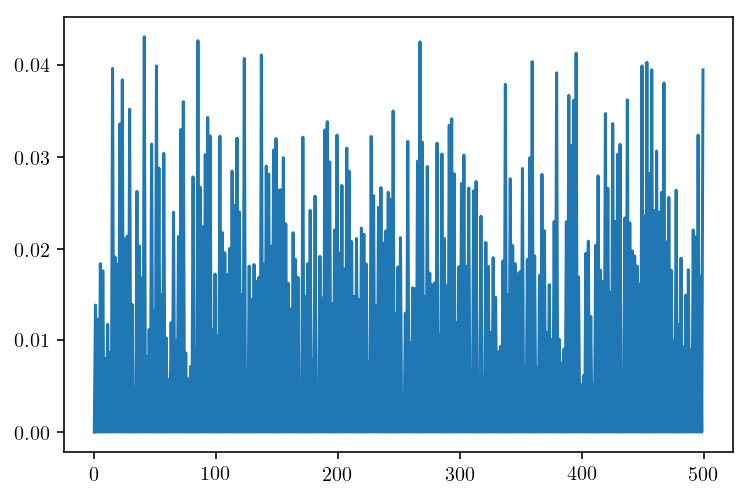

In [35]:
net = ConvNet()
################################################################################
# TODO:                                                                        #
# Choose an Optimizer that will be used to minimize the loss function.         #
# Choose a critera that measures the loss                                      #
################################################################################

criterion = torch.nn.MSELoss()
optimizer = torch.optim.Adam(net.parameters(), lr=0.00001, weight_decay=1e-4)
epochs = 20
steps = 0
running_loss = 0
print_every = 2
vec_acc_ = np.zeros(epochs*25)
for e in range(epochs):
    start = time.time()
    for images, labels in iter(trainloader):
        steps += 1
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Do not forget to transform the inputs and outputs into Variable        #
        # which pytorch uses.                                                          #
        ################################################################################
        inputs = Variable(images)
        targets = Variable(labels)
        optimizer.zero_grad()
        output = net.forward(inputs)
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        loss = criterion(output, targets)
        ################################################################################
        # TODO:                                                                        #
        # Run the training process                                                     #
        #                                                                              #
        # HINT: Calculate the gradient and move one step further                       #
        ################################################################################
        grad = loss.backward()
        optimizer.step()
        ################################################################################
        #                              END OF YOUR CODE                                #
        ################################################################################
        
        running_loss += loss.data[0]
        
        if steps % print_every == 0:
            stop = time.time()
            # Test accuracy
            accuracy = 0
            sum_accuracy = 0
            for ii, (images, labels) in enumerate(valloader):
                ################################################################################
                # TODO:                                                                        #
                # Calculate the accuracy                                                       #
                ################################################################################
                
                inputs = Variable(images)
                targets = Variable(labels)
                predicted = net.predict(inputs)
                accuracy = criterion(predicted, targets)
                accuracy = accuracy.data.numpy().tolist()[0]
                vec_acc_[steps-1] = accuracy/(ii+1)
                sum_accuracy += accuracy
                
                #inputs = Variable(images, volatile=True)
                #predicted = net.predict(inputs)
                #equality = (labels == predicted.max(1)[1])
                #accuracy += equality.type_as(torch.FloatTensor()).mean()
                
                
                #im = Variable(images)
                #out = net.predict(im)
                #_,prediction = torch.max(out, 1)
                #pred_y = prediction.data.numpy().squeeze()
                #target_y = labels.numpy()
                #accuracy = np.mean(predicted == inputs)
                #print(pred_y.shape,target_y.shape)
                
                
                ################################################################################
                #                              END OF YOUR CODE                                #
                ################################################################################
            
            print("Epoch: {}/{}..".format(e+1, epochs),
                  "Loss: {:.4f}..".format(loss.data[0]),
                  "Test accuracy: {:.4f}..".format(sum_accuracy/(ii+1)),
                  "{:.4f} s/batch ".format((stop - start)/print_every),
                  "steps {:.4f}".format(steps)
                 )
            running_loss = 0
            start = time.time()

plt.plot(range(epochs*25),vec_acc_)
plt.show()

In [27]:
vec_acc_

array([0.01840553, 0.00550009, 0.00587005, 0.02756201, 0.0284391 ,
       0.01824291, 0.02176573, 0.0349001 , 0.0385395 , 0.00823474,
       0.02325155, 0.03199237, 0.01350757, 0.02789121, 0.02472419,
       0.0150252 , 0.02402565, 0.02020308, 0.02602012, 0.01936461,
       0.00418759, 0.00688567, 0.03759749, 0.02734746, 0.02060748])

In [94]:
targets

Variable containing:
(0 ,.,.) = 

Columns 0 to 8 
   0.0000  0.0000  0.0000  0.1820 -0.0069  0.0240 -0.0000  0.0000 -0.0000

Columns 9 to 17 
   0.0000 -0.0343  0.1202 -0.1133  0.3056 -0.0790  0.1854 -0.0069  0.0240

(1 ,.,.) = 

Columns 0 to 8 
  -0.0484  1.6810  0.0544  1.7249  0.1391  1.4693 -0.1512  1.6371  0.1308

Columns 9 to 17 
   1.7453  0.2216  1.5895 -0.1762  1.6387  0.3993  1.6288  0.1376  1.4443

(2 ,.,.) = 

Columns 0 to 8 
  -0.7916  1.1444 -0.5575  1.3200 -0.5190  1.2794 -0.6314  1.2192 -0.4451

Columns 9 to 17 
   1.3802 -0.5596  1.2410 -0.6553  1.2119 -0.5720  1.3678 -0.7510  1.1829

(3 ,.,.) = 

Columns 0 to 8 
   0.0968  0.5160  0.3793  0.6665  0.4730  0.6235  0.0015  0.6865 -0.0307

Columns 9 to 17 
   0.5145  0.2411  0.7433  0.3210  0.6266  0.0722  0.5206 -0.0323  0.6419

(4 ,.,.) = 

Columns 0 to 8 
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000

Columns 9 to 17 
   0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000  0.0000


In [83]:
accuracy = np.mean(predicted == inputs)

TypeError: eq received an invalid combination of arguments - got (Variable), but expected one of:
 * (float value)
      didn't match because some of the arguments have invalid types: ([31;1mVariable[0m)
 * (torch.FloatTensor other)
      didn't match because some of the arguments have invalid types: ([31;1mVariable[0m)
